# Cannabis Grow Segmentation with TorchGeo (torchgeo-compatible version)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wxmiked/cannabis-deforestation/blob/main/notebooks/cannabis-segmentation-torchgeo.ipynb)

This script refactors the dataset and dataloaders to use torchgeo's GeoDataset and RandomGeoSampler.

In [1]:
pip install torchgeo segmentation-models-pytorch >& /dev/null

In [2]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # These commands will only run in Google Colab
    !git clone  --single-branch https://github.com/wxmiked/cannabis-deforestation.git # -b feature-use-parcel-bounding-box-instead-of-parcel-shape
    !mv cannabis-deforestation/* ..

Cloning into 'cannabis-deforestation'...
remote: Enumerating objects: 1037, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 1037 (delta 140), reused 173 (delta 121), pack-reused 827 (from 3)
Receiving objects: 100% (1037/1037), 397.01 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (590/590), done.
Updating files: 100% (406/406), done.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchgeo.datasets import GeoDataset
from torchgeo.samplers import RandomGeoSampler
from torchgeo.transforms import AugmentationSequential
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import shape, box
import albumentations as A
from albumentations.pytorch import ToTensorV2
from shapely.geometry import Polygon

In [4]:
# ────────── Cell: Fix CannabisSegmentationGeoDataset ──────────

from pathlib import Path
import json
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Polygon
from torchgeo.datasets import RasterDataset
from rtree import index as rindex
import re
from datetime import datetime
from rasterio.windows import Window
from rasterio.features import rasterize
import numpy as np
import json

class CannabisSegmentationGeoDataset(RasterDataset):
    def __init__(self, annotations_dir, naip_root, transforms=None):
        self.annotation_paths = sorted(Path(annotations_dir).glob("*.json"))
        self.naip_root = Path(naip_root)
        self.filename_glob = "*_*.tif"
        self.filename_regex = r"^.*_(?P<date>\d{8})"
        self.date_format = "%Y%m%d"
        self.is_image = True
        self.separate_files = False
        self.all_bands = ("R", "G", "B", "NIR")
        self.rgb_bands = ("R", "G", "B",)
        self.transforms = transforms

        # Build a mapping from ann_path → image_path
        self.image_paths = {}
        for ann_path in self.annotation_paths:
            ann = json.load(open(ann_path))
            self.image_paths[ann_path] = self.naip_root / ann["imagePath"]

        super().__init__(paths=self.image_paths.values(), transforms=transforms)

        # 1) compute new_bounds
        self._bounds = []
        for ann_path, img_path in self.image_paths.items():
            with rasterio.open(img_path) as src:
                self._crs = src.crs
                b = src.bounds
                self._bounds.append((b.left, b.bottom, b.right, b.top))

        # 3) set the dates
        dates = []
        for fname in self.image_paths.values():
            match = re.match(r"^.*_(\d{8})", fname.name)
            if match:
                date = datetime.strptime(match.group(1), "%Y%m%d")
                dates.append(date.timestamp())
        if dates:
            self.mint = min(dates)
            self.maxt = max(dates)
        else:
            self.mint = 0
            self.maxt = 9223372036854775807

        # 4) update bounds with mint and maxt
        self._bounds = [(b[0], b[1], b[2], b[3], self.mint, self.maxt) for b in self._bounds]

        # 2) rebuild index by hand
        p = rindex.Property()
        p.dimension = 3
        self.index = rindex.Index(properties=p)
        for i, b in enumerate(self._bounds):
            self.index.insert(i, b)

    def __len__(self):
        return len(self.annotation_paths)

    def __getitem__(self, query):
        # Extract size from BoundingBox (or fallback to self.size)
        size = getattr(query, "size", self.size if hasattr(self, 'size') else 128)
        bbox = query["bbox"]
        ann_idx = query["ann_idx"]

        if size is None:
            raise ValueError("Query dict must include 'size'")

        # # 2) 3-D vs 2-D R-tree lookup
        # bbox = tuple(float(x) for x in bbox)
        # if self.index.properties.dimension == 3:
        #     lookup = (bbox[0], bbox[1], self.mint, bbox[2], bbox[3], self.maxt)
        # else:
        #     lookup = bbox
        # idxs = list(self.index.intersection(lookup))
        # if not idxs:
        #     raise ValueError(f"No annotation intersects bbox {bbox}")
        ann_path = self.annotation_paths[ann_idx]
        img_path = self.image_paths[ann_path]

        # 3) open & read fixed window
        with rasterio.open(img_path) as src:
            # center in world → pixel
            cx, cy = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
            rowc, colc = src.index(cx, cy)

            half = size // 2
            col_off = colc - half
            row_off = rowc - half

            # Check center in bounds
            if not (0 <= colc < src.width and 0 <= rowc < src.height):
                # print(f"[DEBUG] OOB center → bbox={bbox}, center_px=({colc},{rowc}), size={size}")
                return None

            # Check window fits
            if col_off < 0 or row_off < 0 or col_off+size > src.width or row_off+size > src.height:
                # print(f"[DEBUG] Window out of image → bbox={bbox}, window=({col_off},{row_off},{size},{size})")
                return None

            window = Window(col_off, row_off, size, size)

            # Read image with this window
            image = src.read(window=window)

            # After reading image
            if image.shape[1] != size or image.shape[2] != size:
                # print(f"[DEBUG] Wrong patch size → image.shape={image.shape}, wanted {size}")
                return None

            _, actual_height, actual_width = image.shape
            if np.all(image == 0):
                # print(f"Warning: Completely blank image patch at {window}")
                return None

            # build mask geometries
            ann = json.load(open(ann_path))
            shapes = [
                (labelme_points_to_geopolygon(s["points"], src.transform), 1)
                for s in ann["shapes"] if s["label"] != "cannabis - old"
            ]

            # Get the transform for the ACTUAL window
            actual_transform = src.window_transform(window)

            # print(f"col_off: {col_off}, row_off: {row_off}, window: {window}")
            # print(f"actual_transform: {actual_transform}")

            # Rasterize mask with the actual transform and shape
            mask = rasterize(
                        shapes,
                        out_shape=(actual_height, actual_width),
                        transform=actual_transform,
                        fill=0,
                        dtype="uint8",
                    )[None]

            assert image.shape[1:] == mask.shape[1:], f"Image and mask shapes do not match: {image.shape}, {mask.shape}"

        # 4) Transformations
        if self.transforms:
            # Apply transforms without normalization
            image, mask_transformed = self.transforms(image, mask[0])
            mask = mask_transformed

        # Make sure image is a tensor before normalization
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).float()
        else:
            image = image.float()

        # Manual normalization with proper tensor types
        num_channels = image.shape[0]
        if num_channels == 4:
            mean = torch.tensor([0.485, 0.456, 0.406, 0.5], device=image.device)
            std = torch.tensor([0.229, 0.224, 0.225, 0.2], device=image.device)
        elif num_channels == 5:  # After NDVI is added
            mean = torch.tensor([0.485, 0.456, 0.406, 0.5, 0.0], device=image.device)
            std = torch.tensor([0.229, 0.224, 0.225, 0.2, 1.0], device=image.device)
        else:
            # Default fallback
            mean = torch.ones(num_channels, device=image.device) * 0.5
            std = torch.ones(num_channels, device=image.device) * 0.2

        # Apply normalization (now both are tensors)
        image = (image - mean[:, None, None]) / std[:, None, None]

        # Return in expected format
        return {"image": image, "mask": mask, "filename": img_path.name.split("/")[-1]}

In [5]:
import random
import numpy as np

random.seed() # default is system time

In [6]:
from typing import List, Tuple
import json, random, rasterio
from rasterio.transform import xy
from shapely.geometry import Polygon, box, Point
from torchgeo.samplers import RandomGeoSampler

def is_valid_bbox(bbox, left, bottom, right, top, polys=None, require_no_intersection=False):
    """Check if bbox is within bounds and (optionally) does not intersect any polygons."""
    within_bounds = (
        bbox[0] >= left and bbox[2] <= right and
        bbox[1] >= bottom and bbox[3] <= top
    )
    if not within_bounds:
        return False
    if require_no_intersection and polys is not None:
        bbox_poly = box(*bbox)
        return not any(p.intersects(bbox_poly) for p in polys)
    return True

def random_point_in_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    for _ in range(50):  # Try up to 50 times
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(p):
            return p.x, p.y
    return None, None  # Failed

def labelme_points_to_geopolygon(points, transform):
    return Polygon([transform * (x, y) for x, y in points])

class PositiveNegativeGeoSampler(RandomGeoSampler):
    def __init__(self, dataset, size, length, pos_fraction=0.5, num_pos_per_poly=1, num_neg_per_image=2, max_attempts=50):
        super().__init__(dataset, size, length)
        self.ds = dataset
        self.size = size
        self.length = length
        self.pos_frac = pos_fraction
        self.pos_bboxes: List[Tuple[float, float, float, float]] = []
        self.neg_bboxes: List[Tuple[float, float, float, float]] = []

        for i, ann_path in enumerate(self.ds.annotation_paths):
            ann = json.load(open(ann_path))
            img_path = self.ds.image_paths[ann_path]
            with rasterio.open(img_path) as src:
                w, h = src.width, src.height
                if w < size or h < size:
                    print(f"Skipping {img_path} (size {w}x{h} < patch {size})")
                    continue

                left, bottom, right, top = src.bounds
                rx, ry = src.res
                half_w = (size / 2) * rx
                half_h = (size / 2) * abs(ry)
                half_w_px = size // 2
                half_h_px = size // 2
                polys = []

                # Collect all polygons
                for shape_ in ann["shapes"]:
                    if shape_["label"] == "cannabis - old":
                        continue
                    poly = labelme_points_to_geopolygon(shape_["points"], src.transform)
                    polys.append(poly)

                # Positive sampling: random points in each polygon
                for poly in polys:
                    for _ in range(num_pos_per_poly):
                        for attempt in range(max_attempts):
                            cx, cy = random_point_in_polygon(poly)
                            if cx is None:
                                continue
                            pb = (cx - half_w, cy - half_h, cx + half_w, cy + half_h)
                            if is_valid_bbox(pb, left, bottom, right, top):
                                self.pos_bboxes.append((i, pb))
                                break

                # Debug
                print(f"{ann_path}: found {len(polys)} positive polygons, {len(self.pos_bboxes)} positive bboxes so far")

                # Negative sampling: random points not intersecting any polygon
                if (w - half_w_px - 1) >= half_w_px and (h - half_h_px - 1) >= half_h_px:
                    for _ in range(num_neg_per_image * max(1, len(polys))):
                        for attempt in range(max_attempts):
                            ix = random.randint(half_w_px, w - half_w_px - 1)
                            iy = random.randint(half_h_px, h - half_h_px - 1)
                            cx2, cy2 = xy(src.transform, iy, ix)
                            nb = (
                                cx2 - half_w,
                                cy2 - half_h,
                                cx2 + half_w,
                                cy2 + half_h,
                            )
                            if is_valid_bbox(nb, left, bottom, right, top, polys, require_no_intersection=True):
                                self.neg_bboxes.append((i, nb))
                                break
                else:
                    print(f"Skipping negative sampling for {img_path} (not enough room for patch)")

        print(f"Positive patches: {len(self.pos_bboxes)}, Negative patches: {len(self.neg_bboxes)}")

    def __iter__(self):
        random.seed()
        pos_count = int(self.length * self.pos_frac)
        neg_count = self.length - pos_count

        already_yielded = set()
        available_pos = list(self.pos_bboxes)
        available_neg = list(self.neg_bboxes)
        random.shuffle(available_pos)
        random.shuffle(available_neg)

        # Yield positive samples
        pos_yielded = 0
        for ann_idx, bbox in available_pos:
            if bbox in already_yielded:
                continue
            already_yielded.add(bbox)
            pos_yielded += 1
            yield {"ann_idx": ann_idx, "bbox": bbox, "size": self.size}
            if pos_yielded >= pos_count:
                break

        # Yield negative samples
        neg_yielded = 0
        for ann_idx, bbox in available_neg:
            if bbox in already_yielded:
                continue
            already_yielded.add(bbox)
            neg_yielded += 1
            yield {"ann_idx": ann_idx, "bbox": bbox, "size": self.size}
            if neg_yielded >= neg_count:
                break

    def __len__(self):
        return self.length

In [7]:
def collate_skip_none(batch):
    # Skip any samples that are None
    count_none = sum(1 for x in batch if x is None)
    # print(f"count of  None in batch: {count_none}, total count: {len(batch)}")
    batch = [x for x in batch if x is not None]
    # If batch is empty, you may want to handle it (raise, return dummy, etc.)
    if len(batch) == 0:
        return None
    # Let default_collate handle the rest
    from torch.utils.data._utils.collate import default_collate
    return default_collate(batch)

In [8]:
!pwd
!ls -l ../cannabis-parcels/cannabis-parcels-masked
from torch.utils.data import DataLoader

naip_root = "../cannabis-parcels/cannabis-parcels-masked"
annotations_dir = "../cannabis-parcels/cannabis-parcels-masked"
dataset = CannabisSegmentationGeoDataset(
    naip_root=naip_root,
    annotations_dir=annotations_dir
)

# ─── Usage ───
patch_size = 256
sampler = PositiveNegativeGeoSampler(
    dataset, size=patch_size, length=1000, pos_fraction=0.9, num_pos_per_poly=10, num_neg_per_image=5
)
loader = DataLoader(dataset, batch_size=32, sampler=sampler, collate_fn=collate_skip_none)

# Visualize one batch
batch = next(iter(loader))
imgs, msks, fnames = batch["image"], batch["mask"], batch["filename"]

/content
total 203860
-rw-r--r-- 1 root root    7190 Jul 29 16:03 10019035_20160620.json
-rw-r--r-- 1 root root 4440616 Jul 29 16:03 10019035_20160620.tif
-rw-r--r-- 1 root root  154360 Jul 29 16:03 10026014_20160620.tif
-rw-r--r-- 1 root root    1114 Jul 29 16:03 10026018_20160620.json
-rw-r--r-- 1 root root  613310 Jul 29 16:03 10026018_20160620.tif
-rw-r--r-- 1 root root    1737 Jul 29 16:03 10027019_20160620.json
-rw-r--r-- 1 root root  146414 Jul 29 16:03 10027019_20160620.tif
-rw-r--r-- 1 root root  138086 Jul 29 16:03 10027020_20160620.tif
-rw-r--r-- 1 root root    1325 Jul 29 16:03 12003015_20160620.json
-rw-r--r-- 1 root root  108662 Jul 29 16:03 12003015_20160620.tif
-rw-r--r-- 1 root root  708414 Jul 29 16:03 12006026_20160620.tif
-rw-r--r-- 1 root root 2254370 Jul 29 16:03 12006028_20160620.tif
-rw-r--r-- 1 root root    1144 Jul 29 16:03 12007001_20160620.json
-rw-r--r-- 1 root root 1521740 Jul 29 16:03 12007001_20160620.tif
-rw-r--r-- 1 root root     882 Jul 29 16:03 12007

## Data Augmentation

In [9]:
import torch
from torchgeo.transforms import AppendNDVI

def get_transforms(patch_size):
    class MinimalTransform:
        def __init__(self, is_train=True):
            self.is_train = is_train
            # No normalization here - we'll add it separately
            self.ndvi = AppendNDVI(index_red=0, index_nir=3)

        def __call__(self, image, mask=None):
            # Convert to tensor if needed
            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(image).float()
            else:
                image = image.float()

            if mask is not None and not isinstance(mask, torch.Tensor):
                mask = torch.from_numpy(mask).float()
                if mask.dim() == 2:
                    mask = mask.unsqueeze(0)

            # Simple augmentations
            if self.is_train:
                # Horizontal flip
                if torch.rand(1).item() < 0.5:
                    image = torch.flip(image, dims=[2])
                    if mask is not None:
                        mask = torch.flip(mask, dims=[2])

                # Vertical flip
                if torch.rand(1).item() < 0.5:
                    image = torch.flip(image, dims=[1])
                    if mask is not None:
                        mask = torch.flip(mask, dims=[1])

                # Rotation
                if torch.rand(1).item() < 0.5:
                    k = torch.randint(1, 4, (1,)).item()
                    image = torch.rot90(image, k=k, dims=[1, 2])
                    if mask is not None:
                        mask = torch.rot90(mask, k=k, dims=[1, 2])

            # Skip normalization completely

            # Apply NDVI transform
            image = self.ndvi(image)

            return image, mask

    train_transform = MinimalTransform(is_train=True)
    val_transform = MinimalTransform(is_train=False)
    return train_transform, val_transform

In [10]:
## U-Net Model Architecture (unchanged)

import torch.nn.functional as F
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class UNetWithResNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=1, pretrained=True):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        # Modify first conv layer to accept 4 channels
        w = resnet.conv1.weight
        resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if n_channels == 4:
            resnet.conv1.weight.data[:, :3, :, :] = w.data
            resnet.conv1.weight.data[:, 3:, :, :].zero_()
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        self.center = nn.Sequential(
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )
        self.decoder4 = DecoderBlock(2048, 1024, 1024)
        self.decoder3 = DecoderBlock(1024, 512, 512)
        self.decoder2 = DecoderBlock(512, 256, 256)
        self.decoder1 = DecoderBlock(256, 64, 64)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, n_classes, kernel_size=1),
            nn.Sigmoid()
        )
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, x):
        input_size = x.size()[2:]
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        e0 = x
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e4 = self.center(e4)
        d4 = self.decoder4(e4, e3)
        d3 = self.decoder3(d4, e2)
        d2 = self.decoder2(d3, e1)
        d1 = self.decoder1(d2, e0)
        out = self.final_conv(d1)
        out = self.final_up(out)
        if out.size()[2:] != input_size:
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        return out

In [11]:
## Training Loop (unchanged)

from torch.utils.data import DataLoader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    num_epochs: int,
    device: torch.device
) -> Tuple[List[float], List[float]]:
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        for batch_idx, batch in enumerate(train_loader):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device).float()

            # Check for extra dimension and reshape if needed
            if images.dim() == 5:  # If you have [batch, 1, channels, height, width]
                images = images.squeeze(1)  # Remove the extra dimension -> [batch, channels, height, width]

            # If masks also have an extra dimension
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)

            # Check if masks are missing the channel dimension
            if masks.dim() == 3:  # [batch, height, width]
                masks = masks.unsqueeze(1)  # Add channel dimension: [batch, 1, height, width]

            optimizer.zero_grad()
            outputs = model(images)
            if batch_idx == 0 and epoch == 0:
                print(f"Outputs: {outputs.shape}\n")
                assert outputs.shape == masks.shape, \
                    f"Shape mismatch: outputs {outputs.shape} vs masks {masks.shape}"
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1
        train_loss = epoch_loss / batch_count
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        val_count = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                masks = batch["mask"].to(device).float()

                # Fix dimensions
                if images.dim() == 5:
                    images = images.squeeze(1)

                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_count += 1
        val_loss = val_loss / val_count
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 40)
    return train_losses, val_losses

In [12]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # If logits, apply sigmoid
        inputs = torch.sigmoid(inputs)
        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, smooth=1.):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.smooth = smooth

    def forward(self, inputs, targets):
        bce = self.bce(inputs, targets)
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return self.bce_weight * bce + (1 - self.bce_weight) * (1 - dice)

In [13]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",
    encoder_weights="imagenet",
    # encoder_weights=None,
    in_channels=5,
    classes=1
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

## Main Training Script

mkdir: cannot create directory ‘../models’: File exists
../cannabis-parcels/cannabis-parcels-masked/10019035_20160620.json: found 12 positive polygons, 90 positive bboxes so far
../cannabis-parcels/cannabis-parcels-masked/10026018_20160620.json: found 1 positive polygons, 100 positive bboxes so far
Skipping ../cannabis-parcels/cannabis-parcels-masked/10027019_20160620.tif (size 128x285 < patch 256)
Skipping ../cannabis-parcels/cannabis-parcels-masked/12003015_20160620.tif (size 168x161 < patch 256)
../cannabis-parcels/cannabis-parcels-masked/12007001_20160620.json: found 2 positive polygons, 120 positive bboxes so far
Skipping ../cannabis-parcels/cannabis-parcels-masked/12007017_20160620.tif (size 267x139 < patch 256)
Skipping ../cannabis-parcels/cannabis-parcels-masked/12008016_20160620.tif (size 171x320 < patch 256)
../cannabis-parcels/cannabis-parcels-masked/12009005_20160620.json: found 3 positive polygons, 130 positive bboxes so far
Skipping ../cannabis-parcels/cannabis-parcels-ma

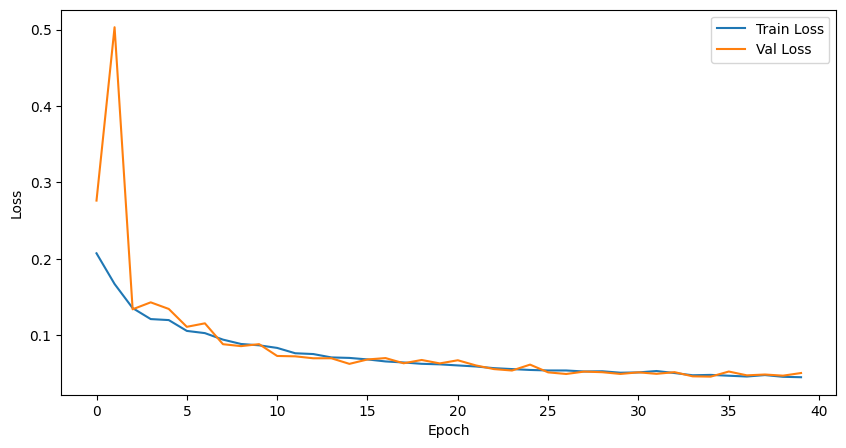

In [15]:
!mkdir ../models
# patch_size = 512  # defined earlier
batch_size = 256
num_epocs = 40

naip_root = "../cannabis-parcels/cannabis-parcels-masked"
annotations_dir = "../cannabis-parcels/cannabis-parcels-masked"
train_transform, val_transform = get_transforms(patch_size)
train_dataset = CannabisSegmentationGeoDataset(
    naip_root=naip_root,
    annotations_dir=annotations_dir,
    transforms=train_transform
)
val_dataset = CannabisSegmentationGeoDataset(
    naip_root=naip_root,
    annotations_dir=annotations_dir,
    transforms=val_transform
)
# Use RandomGeoSampler
# Shared sampler parameters
length = 1000
pos_fraction = 0.9
num_pos_per_poly = 10
num_neg_per_image = 5

train_sampler = PositiveNegativeGeoSampler(
    train_dataset,
    size=patch_size,
    length=length,
    pos_fraction=pos_fraction,
    num_pos_per_poly=num_pos_per_poly,
    num_neg_per_image=num_neg_per_image
)

val_sampler = PositiveNegativeGeoSampler(
    val_dataset,
    size=patch_size,
    length=int(length * 0.2),  # 20% of train_sampler's length
    pos_fraction=pos_fraction,
    num_pos_per_poly=num_pos_per_poly,
    num_neg_per_image=num_neg_per_image
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_skip_none)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=collate_skip_none)
# Model, loss, optimizer (use new UNetWithResNet)
# model = UNetWithResNet(n_channels=4, n_classes=1, pretrained=True).to(device)

# Reload the already trained model
# model = UNetWithResNet(n_channels=4, n_classes=1, pretrained=False)
# model.load_state_dict(torch.load("../models/cannabis-segmentation-model.pth", map_location=device))
# model = model.to(device)
# model.eval()

# Criterion
# criterion = nn.BCELoss()
criterion = DiceLoss()
criterion = BCEDiceLoss(bce_weight=0.5)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epocs,
    device=device
)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
torch.save(model.state_dict(), "../models/cannabis-segmentation-model.pth")

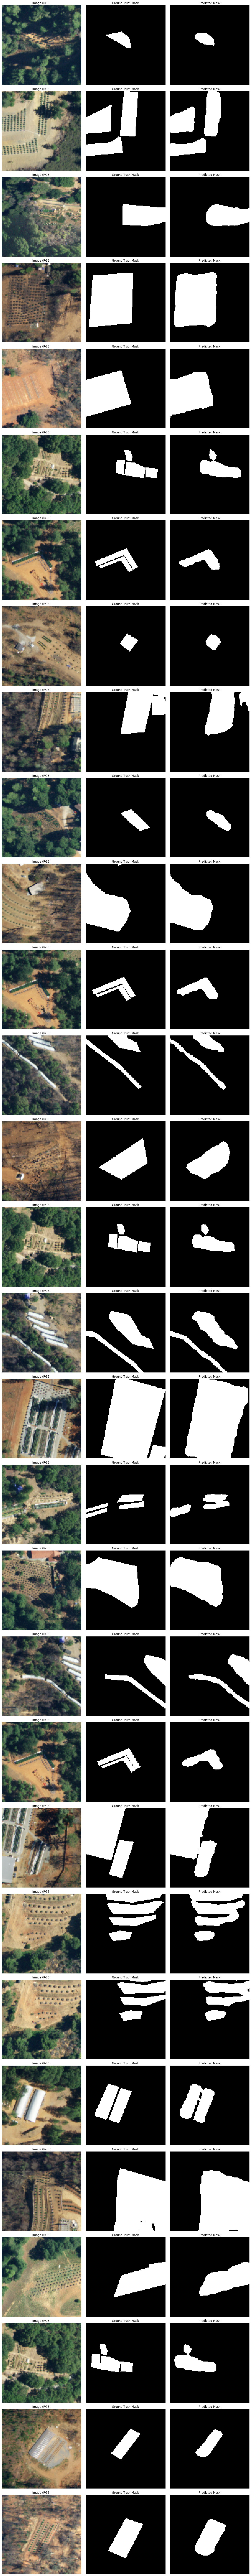

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img, mean, std, bands=None):
    """
    Unnormalize an image using mean and std
    img: numpy array of shape (H,W,C) or (C,H,W)
    mean, std: numpy arrays of shape (C,)
    bands: tuple of indices to select (e.g., (0,1,2) for RGB)
    """
    # Convert to HWC if in CHW format
    if img.shape[0] == 3 or img.shape[0] == 4 or img.shape[0] == 5:  # CHW format
        img = img.transpose(1, 2, 0)

    # Select bands if specified
    if bands is not None:
        img = img[:, :, bands]
        mean = mean[list(bands)]
        std = std[list(bands)]

    # Apply unnormalization
    img = img * std + mean
    return np.clip(img, 0, 1)

def show_batch(images, masks, preds, num_samples=30):
    """
    Simple display function for satellite imagery - no normalization
    """
    fig, axs = plt.subplots(min(num_samples, len(images)), 3, figsize=(15, 5*min(num_samples, len(images))))

    if num_samples == 1:
        axs = axs.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        # Get RGB bands or first 3 bands if we have enough
        img = images[i]

        # Convert to HWC if in CHW format
        if len(img.shape) == 3 and (img.shape[0] == 3 or img.shape[0] == 4 or img.shape[0] == 5):
            img = img.transpose(1, 2, 0)

        # Just take the first 3 bands for RGB display
        if img.shape[-1] >= 3:
            img_rgb = img[:, :, :3]
        else:
            # For fewer bands, duplicate the first band
            img_rgb = np.repeat(img[:, :, 0:1], 3, axis=-1)

        # Simple rescaling to [0,1] for display
        img_min, img_max = img_rgb.min(), img_rgb.max()
        if img_max > img_min:  # Avoid division by zero
            img_rgb = (img_rgb - img_min) / (img_max - img_min)

        # Display the images with auto-scaling
        axs[i, 0].imshow(img_rgb)
        axs[i, 0].set_title("Image (RGB)")
        axs[i, 0].axis("off")

        # Process masks and predictions - ensure they're 2D arrays
        mask = masks[i]
        pred = preds[i]

        # Squeeze out single dimensions if present
        if len(mask.shape) == 3 and mask.shape[0] == 1:
            mask = mask[0]

        if len(pred.shape) == 3 and pred.shape[0] == 1:
            pred = pred[0]

        # Display masks and predictions
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(pred, cmap='gray')
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load model
model.load_state_dict(torch.load("../models/cannabis-segmentation-model.pth", map_location=device))
model = model.to(device)
model.eval()

# 3. Get a batch from your validation loader
batch = next(iter(val_loader))
images = batch["image"].to(device)
masks = batch["mask"].to(device).float()

# 4. Run inference
with torch.no_grad():
    # Fix the image dimensions before inference
    if images.dim() == 5:  # If shape is [batch, 1, channels, height, width]
        images = images.squeeze(1)  # Now shape should be [batch, channels, height, width]

    outputs = model(images)
    preds = (outputs > 0.5).float()

# 5. Visualize using the helper function
images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy()
preds_np = preds.cpu().numpy()

mean = np.array([0.485, 0.456, 0.406, 0.5, 0.0])  # Added 0.0 for NDVI
std = np.array([0.229, 0.224, 0.225, 0.5, 1.0])   # Added 1.0 for NDVI

show_batch(images_np, masks_np, preds_np)